In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('^HSI','2018-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26014/3467137344.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close
Date,,,,,
2018-01-02,30028.289062,30515.310547,30028.289062,30515.310547,30515.310547
2018-01-03,30658.730469,30724.320312,30456.759766,30560.949219,30560.949219
2018-01-04,30691.710938,30796.929688,30560.429688,30736.480469,30736.480469
2018-01-05,30893.859375,30911.009766,30638.529297,30814.640625,30814.640625
2018-01-08,30895.089844,30929.150391,30732.539062,30899.529297,30899.529297
...,...,...,...,...,...
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26014/1968958741.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


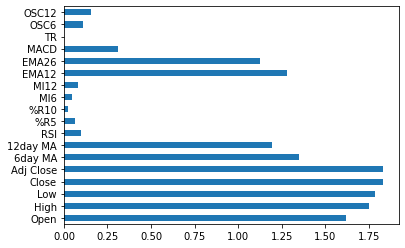

In [4]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26014/244261082.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


,Open,High,Low,Close,Adj Close,6day MA,12day MA,EMA12,EMA26,MACD,Prediction
Date,,,,,,,,,,,
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23113.381836,23494.919108,23394.847996,23829.572972,-434.724976,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23071.425130,23430.493327,23368.526730,23784.697920,-416.171190,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.080078,23349.301758,23354.993471,23747.354411,-392.360940,23086.539062
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062,23143.026693,23273.536621,23313.692793,23698.405126,-384.712333,23112.009766
2021-12-30,23130.449219,23248.259766,22990.240234,23112.009766,23112.009766,23166.473307,23203.322428,23282.664635,23654.968432,-372.303797,23397.669922


In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
# data['Prediction']=data['Close'].shift(-1)
# data.dropna(inplace=True)
# data_val=data[-100:]
# data=data[:-100]
# data_val.tail()

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(682, 1, 10) (682,) (171, 1, 10) (171,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26014/759405757.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
#     kernel_regularizer=regularizers.l2(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-12 17:08:33.465304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 17:08:33.465445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 17:08:34.464565: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 17:08:35.687320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:08:35.926107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:08:36.433259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:08:37.724790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:08:38.243475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 6s 51ms/step - loss: 748885760.0000 - val_loss: 623379520.0000
Epoch 2/500
 1/39 [..............................] - ETA: 0s - loss: 960222080.0000

2022-04-12 17:08:40.319355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:08:40.393200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:08:40.417789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 10ms/step - loss: 748689728.0000 - val_loss: 623259200.0000
Epoch 3/500
39/39 [==============================] - 0s 10ms/step - loss: 747116032.0000 - val_loss: 622741504.0000
Epoch 4/500
39/39 [==============================] - 0s 9ms/step - loss: 743189504.0000 - val_loss: 619419840.0000
Epoch 5/500
39/39 [==============================] - 0s 10ms/step - loss: 736200448.0000 - val_loss: 609359360.0000
Epoch 6/500
39/39 [==============================] - 0s 10ms/step - loss: 726541184.0000 - val_loss: 598285248.0000
Epoch 7/500
39/39 [==============================] - 0s 11ms/step - loss: 715959168.0000 - val_loss: 587858752.0000
Epoch 8/500
39/39 [==============================] - 0s 12ms/step - loss: 704473536.0000 - val_loss: 576878208.0000
Epoch 9/500
39/39 [==============================] - 0s 11ms/step - loss: 692036032.0000 - val_loss: 565091520.0000
Epoch 10/500
39/39 [==============================] - 0s 10ms/step - loss: 678671872.

39/39 [==============================] - 0s 9ms/step - loss: 318953.7188 - val_loss: 75194.2734
Epoch 147/500
39/39 [==============================] - 0s 9ms/step - loss: 310694.5625 - val_loss: 73537.4844
Epoch 148/500
39/39 [==============================] - 0s 9ms/step - loss: 302695.6875 - val_loss: 71955.1250
Epoch 149/500
39/39 [==============================] - 0s 9ms/step - loss: 294945.7500 - val_loss: 70453.0703
Epoch 150/500
39/39 [==============================] - 0s 9ms/step - loss: 287433.2812 - val_loss: 69035.5156
Epoch 151/500
39/39 [==============================] - 0s 9ms/step - loss: 280148.7812 - val_loss: 67706.5938
Epoch 152/500
39/39 [==============================] - 0s 9ms/step - loss: 273083.3438 - val_loss: 66469.1953
Epoch 153/500
39/39 [==============================] - 0s 9ms/step - loss: 266229.6250 - val_loss: 65325.8359
Epoch 154/500
39/39 [==============================] - 0s 9ms/step - loss: 259580.1875 - val_loss: 64278.6016
Epoch 155/500
39/39 [===

39/39 [==============================] - 0s 10ms/step - loss: 125233.8672 - val_loss: 62402.8711
Epoch 295/500
39/39 [==============================] - 0s 9ms/step - loss: 130776.5625 - val_loss: 70930.0312
Epoch 296/500
39/39 [==============================] - 0s 10ms/step - loss: 117585.1719 - val_loss: 59890.3203
Epoch 297/500
39/39 [==============================] - 0s 10ms/step - loss: 122117.7656 - val_loss: 68004.3203
Epoch 298/500
39/39 [==============================] - 0s 9ms/step - loss: 114542.4844 - val_loss: 58984.6055
Epoch 299/500
39/39 [==============================] - 0s 9ms/step - loss: 118498.4297 - val_loss: 66939.2031
Epoch 300/500
39/39 [==============================] - 0s 10ms/step - loss: 113365.0938 - val_loss: 58679.6602
Epoch 301/500
39/39 [==============================] - 0s 9ms/step - loss: 117140.1875 - val_loss: 67068.9062
Epoch 302/500
39/39 [==============================] - 0s 9ms/step - loss: 113053.0391 - val_loss: 58599.6523
Epoch 303/500
39/39 

39/39 [==============================] - 0s 10ms/step - loss: 126836.4531 - val_loss: 60997.2422
Epoch 443/500
39/39 [==============================] - 0s 9ms/step - loss: 117270.3281 - val_loss: 77976.4922
Epoch 444/500
39/39 [==============================] - 0s 11ms/step - loss: 126447.6328 - val_loss: 61039.8984
Epoch 445/500
39/39 [==============================] - 0s 11ms/step - loss: 116978.5703 - val_loss: 77789.6719
Epoch 446/500
39/39 [==============================] - 0s 9ms/step - loss: 126093.9531 - val_loss: 61087.2539
Epoch 447/500
39/39 [==============================] - 0s 9ms/step - loss: 116747.4219 - val_loss: 77676.6953
Epoch 448/500
39/39 [==============================] - 0s 9ms/step - loss: 125801.0859 - val_loss: 61135.8359
Epoch 449/500
39/39 [==============================] - 0s 9ms/step - loss: 116580.0469 - val_loss: 77637.2188
Epoch 450/500
39/39 [==============================] - 0s 9ms/step - loss: 125583.8594 - val_loss: 61183.7031
Epoch 451/500
39/39 [

2022-04-12 17:11:52.600635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:11:52.681092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 17:11:52.782789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


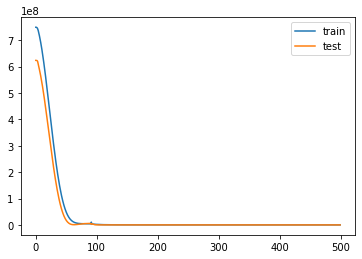

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

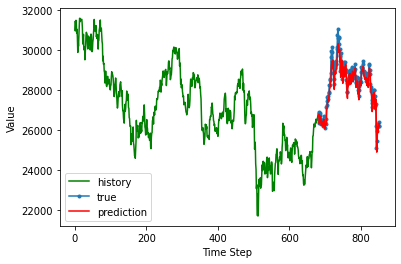

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

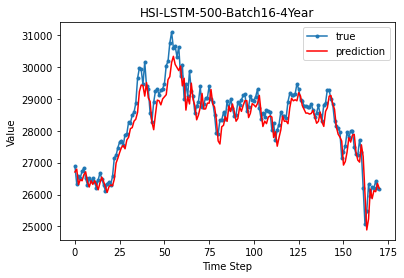

In [22]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-500-Batch16-4Year')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.8735760182168951

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

0.011745157644701302

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

420.0367099582886

In [17]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26014/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


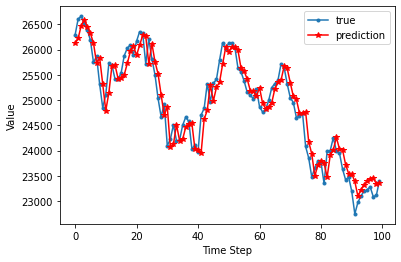

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.9077683432024527

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.009973095084810736

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

305.0773672097538